In [1]:
import numpy as np
from tqdm.auto import tqdm

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def add_colorbar(vec, ax, label):
    normalize = mcolors.Normalize(vmin=vec.min(), vmax=vec.max())
    colormap = plt.cm.plasma
    scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(vec)
    cbar = fig.colorbar(scalarmappaple, ax = ax)
    cbar.set_label(label)

# $P(L)$

In [3]:
def prob_L(L, Ps):
    '''
    :L (scalar): number of steps
    :Ps (array): probability of staying, at each L
    '''    
    return (1-Ps[L])*np.prod(Ps[:L])

# Constant $P_s$

In [10]:
L_max = 50
Ps = np.ones(L_max)*(1/2)

p_l = []
for l in range(0, L_max-1):
    p_l.append(prob_L(l, Ps))    

(0.0001, 1)

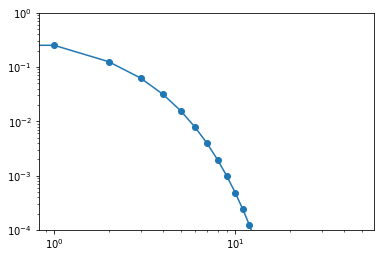

In [11]:
plt.loglog(p_l, 'o-')
plt.ylim(1e-4,1)

**Numerical check**

In [16]:
runs = int(1e6)
num_l = np.zeros(runs)

for run in tqdm(range(runs)):
    
    for l in range(L_max):
        if np.random.rand() > Ps[l]:
            break
            
    num_l[run] = l
counts = np.bincount(num_l.astype(int))

  0%|          | 0/1000000 [00:00<?, ?it/s]

(1e-06, 1)

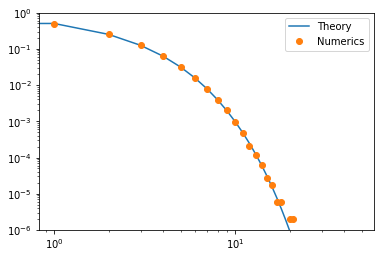

In [19]:
plt.loglog(p_l/max(p_l), label = 'Theory')
plt.loglog(counts/max(counts), 'o', label = 'Numerics')
plt.legend()
plt.ylim(1e-6,1)

# Reaching power law $P(L)$ - recurrent calculation of $P_s(l)$

In [4]:
from scipy.special import zeta

def get_ps(L, alpha, ps_0 = 1):
    
    ps = np.zeros(L)
    ps[0] = ps_0    
    
    for l in range(2, L+1):
                
        # product
        prod = np.prod(ps[:l-1])
        # P(L-1)
        p_lm1 = (1/zeta(alpha+1, q = 1))*(l-1)**(-alpha-1)
        # all together
        ps[l-1] = 1-p_lm1/prod
        
    return ps

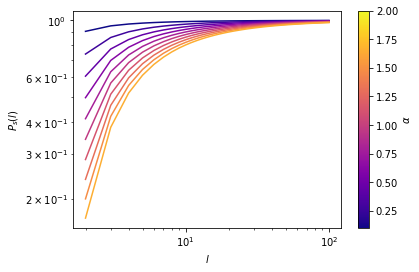

In [512]:
L = 100
alphas = np.linspace(0.1, 2, 10)
colors = plt.cm.plasma(np.linspace(0,1,len(alphas)+2))

fig, ax = plt.subplots()
for alpha, color in zip(alphas, colors):
    ps = get_ps(L, alpha = alpha, ps_0 = 1)
    ax.loglog(np.arange(2, L+1), ps[1:], c = color)
plt.setp(ax, xlabel =r'$l$', ylabel = r'$P_s(l)$')

add_colorbar(alphas, ax, r'$\alpha$')

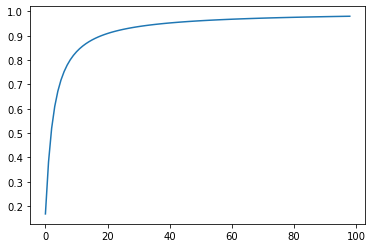

In [6]:
plt.plot(get_ps(100, alpha = 2, ps_0 = 1)[1:])

## Computing $P(L)$ from $P_s$

#### Normal scenario

In [25]:
L = 5000
alpha = 1.2
ps = get_ps(L, alpha = alpha)

p_l = []
for l in range(1, L):
    p_l.append(prob_L(l, ps))

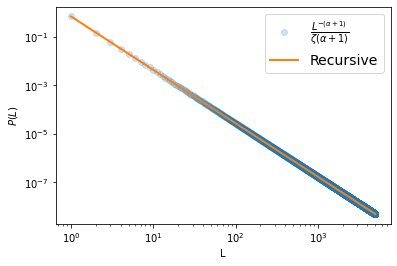

In [30]:
PL= (1/zeta(alpha+1, q = 1))*np.arange(1,L).astype(float)**(-1-alpha)
plt.loglog(np.arange(1,L), PL, 'o', alpha = 0.2, label = r'$\frac{L^{-(\alpha+1)}}{\zeta(\alpha+1)}$')
plt.loglog(np.arange(1,L), p_l, lw = 2, label = 'Recursive')

# plt.loglog(np.arange(1,L).astype(float)**(-1))
plt.xlabel('L'); plt.ylabel(r'$P(L)$')
# plt.ylim(1e-8, 1)
plt.legend(fontsize = 14)

#### Considering a cutoff after $n$ steps

In [31]:
ps_cutoff = get_ps(L, alpha = alpha)
ps_cutoff[50:] = ps_cutoff[30]

L_max = L
Ps = ps_cutoff.copy()
Pr = 1-Ps

p_l_cutoff = []
for l in range(1, L_max):
    p_l_cutoff.append(prob_L(l, Ps))

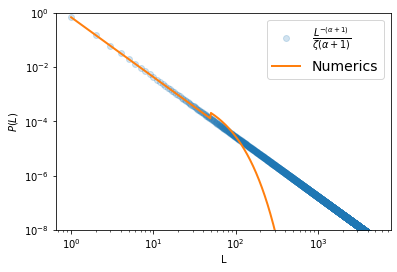

In [40]:
PL= (1/zeta(alpha+1, q = 1))*np.arange(1,L).astype(float)**(-1-alpha)
plt.loglog(np.arange(1,L), PL, 'o', alpha = 0.2, label = r'$\frac{L^{-(\alpha+1)}}{\zeta(\alpha+1)}$')
plt.loglog(np.arange(1,L), p_l_cutoff, lw = 2, label = 'Numerics')

# plt.loglog(np.arange(1,L).astype(float)**(-1))
plt.xlabel('L'); plt.ylabel(r'$P(L)$')
plt.ylim(1e-8, 1)
plt.legend(fontsize = 14)

# Simulating walks from $P_s$
We will simulate the walk of an agent with policy $P_s$ such as to have a power law $P(L)$. This should translate into superdiffusive walks. From [Zaburdaev's review](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.87.483), we should have a walk following:
$$
  \left <x^2(t)\right> \propto
    \begin{cases}
      t^2 & 0 < \alpha < 1, \\ t^2/\ln t & \alpha = 1, \\ t^{3-\alpha} & 1<\alpha <2, \\
      t\ln t & \alpha = 2 \\ t & \alpha > 2
    \end{cases}       
$$

In [38]:
def walk_from_policy(T, policy):
    '''Inputs:
    :T (int): Number of steps
    :policy (array): probability of staying in same direction at each time. If at some point
                     time > len(policy), the agent will rotate.
                     
     Ps(1) = 1 IS ALREADY CONSIDERED, DON'T INPUT IT!!!'''
    
    pos = np.zeros((T, 2))    
    direction = np.random.rand()*360 
    internal_clock = 0
    for t in range(1, T):   
        pos[t, 0] = pos[t-1, 0] + np.cos(direction)
        pos[t, 1] = pos[t-1, 1] + np.sin(direction)
        
        if np.random.rand() > policy[internal_clock]:
            internal_clock = 0
            direction = np.random.rand()*360 
        else:
            internal_clock += 1
            
    return pos    

In [59]:
T = 1000; N = 100
alphas = np.linspace(0, 2, 100)

msd = np.zeros((len(alphas), 2*N, T))
for idxa, alpha in enumerate(tqdm(alphas)):

    ps = get_ps(L = T, alpha = alpha)
    
    for idx in (range(100)):
        pos = walk_from_policy(T = T, policy = ps[1:])

        msd[idxa, idx, :] = pos[:, 0]
        msd[idxa, 2*idx, :] = pos[:, 1]
    
#     exp = np.mean([msd_analysis().get_exponent(pos[:,0]), msd_analysis().get_exponent(pos[:,1])])
#     exponent.append(exp)

  0%|          | 0/100 [00:00<?, ?it/s]

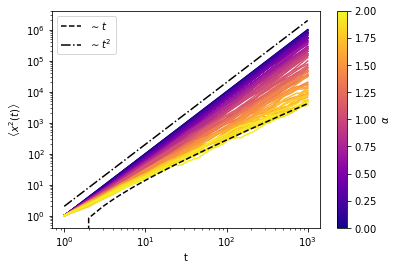

In [71]:
colors = plt.cm.plasma(np.linspace(0,1,len(alphas)+2))
fig, ax = plt.subplots()

for m, c in zip(msd, colors):
    m = (m.copy()**2).mean(0)
    ax.loglog(np.arange(1, T), m[1:]/m[1], c = c)

ax.plot(np.arange(1, T), 0.6*np.arange(1, T)*np.log(np.arange(1, T)), '--', c = 'k', label = r'$\sim t$')
ax.plot(np.arange(1, T), 2*np.arange(1, T)**2, '-.', c = 'k', label = r'$\sim t^2$')
add_colorbar(alphas, ax, r'$\alpha$')
plt.setp(ax, xlabel = 't', ylabel = r'$\left < x^2 (t) \right >$')
ax.legend()

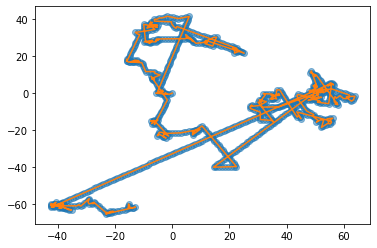

In [46]:
plt.plot(pos[:,0], pos[:, 1], 'o', alpha = 0.5)
plt.plot(pos[:,0], pos[:, 1])

# Simulating learning
We will simulate the learning of an agent exploring a target environment. For a given environment, we set the optimal $\alpha$. To begin we consider $\alpha\rightarrow 2$. Then, the targets must be collected at the end of the steps sampled from this distribution. We reward this sequence of steps (consider $\eta$ glow, a.k.a. discount factor).

In [100]:
class simul_ps():
    def __init__(self, num_states, eta, gamma):     
        
        self.num_states = num_states
    
        self.h_matrix = np.ones(num_states)        
        self.eta = eta
        self.gamma_damping = gamma
    
    def reward(self, state, reward = 1):
        
        g_matrix = np.zeros(self.num_states)
        g_matrix[:state] = (self.eta**np.arange(state))[::-1]
        
        self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + g_matrix * reward
        
        
        
        

In [83]:
def discrete_pw_sample(alpha, L_max=1000, num_samples = 1):
    probs = (1/zeta(alpha+1, q = 1))*(np.arange(1, L_max).astype(float)**(-alpha-1))
    # normalize to take into accont L_max not infinity
    probs /= np.sum(probs)
    return np.random.choice(np.arange(1, L_max), p = probs, size = num_samples)

In [97]:
samples = discrete_pw_sample(2, num_samples=int(1e5))

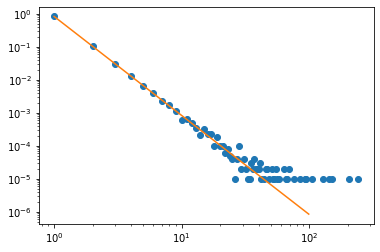

In [98]:
u, c = np.unique(samples, return_counts=True)
plt.loglog(u, c/np.sum(c), 'o')
plt.loglog(np.arange(1,L), probs)

## simul training 

In [108]:
epochs = int(1e5)
ps = simul_ps(num_states = 1000,
              eta = 1,
              gamma = 0)
alpha = 2
for e in tqdm(range(epochs)):
    
    step = int(discrete_pw_sample(alpha))
    ps.reward(state = step)
    

  0%|          | 0/100000 [00:00<?, ?it/s]

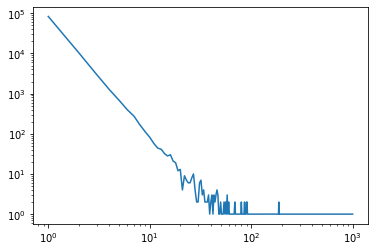

In [109]:
plt.loglog(np.arange(1, ps.num_states+1), ps.h_matrix)

In [124]:
def policy_theory(l, eta, alpha, reward = 1, L_max = int(1e4)):
    
    probs = (1/zeta(alpha+1, q = 1))*(np.arange(l, L_max).astype(float)**(-alpha-1))
    etas_exp = (eta**np.arange(L_max-l))
    
    return (probs*etas_exp*reward).sum()

In [139]:
L_max = int(1e4); eta = 1; alpha = 1.01
p = []
for l in range(1, L_max):
    p.append(policy_theory(l, eta, alpha))
    

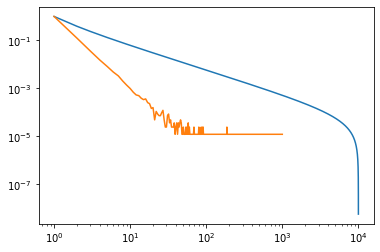

In [140]:
plt.loglog(np.arange(1, L_max), p)
plt.loglog(np.arange(1, ps.num_states+1), ps.h_matrix/ps.h_matrix[0])

In [123]:
l = 1
L_max = 10
eta**np.arange(L_max-l)

array([1.        , 0.5       , 0.25      , 0.125     , 0.0625    ,
       0.03125   , 0.015625  , 0.0078125 , 0.00390625])